# Multi-Class Detection of Key Roles in Football 

## Project work in Deep Learning 

## Author: Luigi Manieri - 0001113044

Accurately identifying and classifying key roles (such as players, referees, coaches and goalkeepers) from match footage is essential for advanced sports analytics, tactical evaluation, and performance optimization.

This notebook focuses on building a deep learning–based multi-class detection model to automate the recognition of player roles in football videos. The goal is to enable fast, consistent, and scalable analysis of on-field dynamics, offering a significant improvement over manual tagging methods in both efficiency and analytical depth.

## Dataset: Images of football matches

* dataset/train - A directory containing the training set images. Each image is named with a unique, randomly generated identifier and is in PNG format.

* dataset/train/_annotations.coco.json - This JSON file is formatted according to the COCO data format, containing bounding box annotations for objects identified in the training set images.

### Import libraries 

In [177]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import json

import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torch.optim as optim
from pycocotools.coco import COCO

from PIL import Image
import numpy as np
import os

import json
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from torchvision import transforms as T
from torchvision.transforms import v2 as T2

from tqdm import tqdm

### Load data

In [178]:
dataset_dir = 'dataset'

os.listdir(dataset_dir)

['test', 'test.csv', 'train', 'val']

In [179]:
training_dir = f"{dataset_dir}/train"
files = os.listdir(training_dir)

In [180]:
is_json = lambda x: x.endswith("json")
is_img = lambda x: x.endswith("jpg")

In [181]:
coco_json = next(filter(is_json, files))

In [182]:
with open(f"{training_dir}/{coco_json}") as coco_file:
    coco_json = json.load(coco_file)
    # print(coco_json.keys())
    coco_annotations = coco_json.get("annotations")

### Exploratory data analysis

* The data has already been filtered and appears clean enough for further processing.
* Each file has a unique name, ensuring there are no duplicates.

In [183]:
categories = coco_json['categories']
category_map = {cat['id']: cat['name'] for cat in categories}


category_counts = {cat['id']: 0 for cat in categories}

for ann in coco_json['annotations']:
    category_counts[ann['category_id']] += 1

In [184]:
categories_names = [cat['name'] for cat in categories]

categories_names[1:]

['ball', 'coach', 'goalkeeper', 'player', 'referee']

In [185]:
class_distribution = pd.DataFrame([
    {'category_id': cat_id, 'category_name': category_map[cat_id], 'count': count} 
    for cat_id, count in category_counts.items()
])

# Sort by count
class_distribution = class_distribution.sort_values('count', ascending=False)

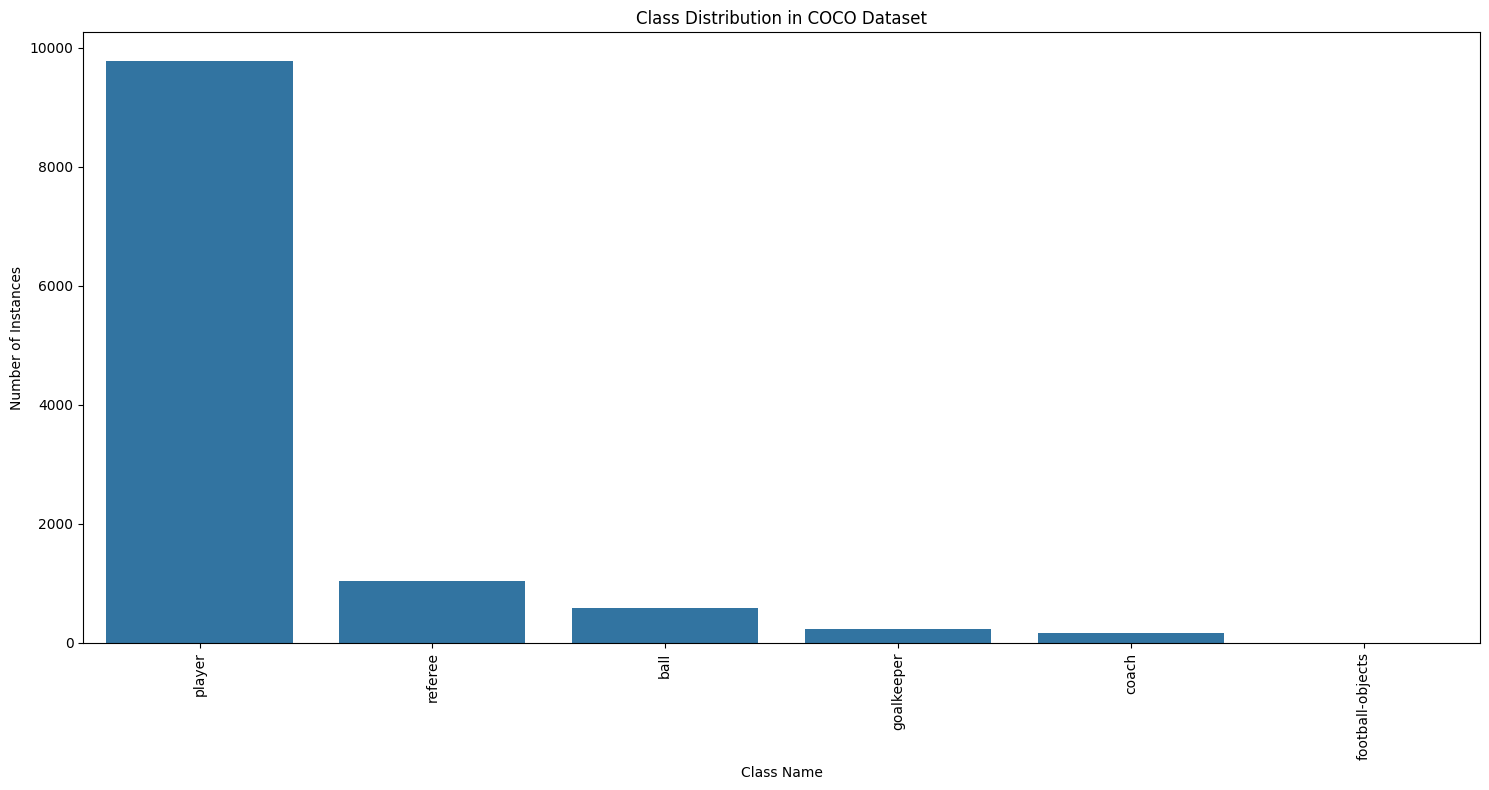

In [186]:
plt.figure(figsize=(15, 8))
sns.barplot(data=class_distribution, x='category_name', y='count')
plt.title('Class Distribution in COCO Dataset')
plt.xlabel('Class Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [187]:
# Print basic statistics
print("Class Distribution Statistics:")
print(f"Total number of classes: {len(class_distribution)-1}")  # Exclude background class
print(f"Total number of instances: {class_distribution['count'].sum()}")
print(f"Average instances per class: {class_distribution['count'].mean():.1f}")
print(f"Class with most instances: {class_distribution.iloc[0]['category_name']} ({class_distribution.iloc[0]['count']})")
# print(f"Class with least instances: {class_distribution.iloc[-1]['category_name']} ({class_distribution.iloc[-1]['count']})")

# Calculate imbalance ratio
max_count = class_distribution['count'].max()

Class Distribution Statistics:
Total number of classes: 5
Total number of instances: 11786
Average instances per class: 1964.3
Class with most instances: player (9773)


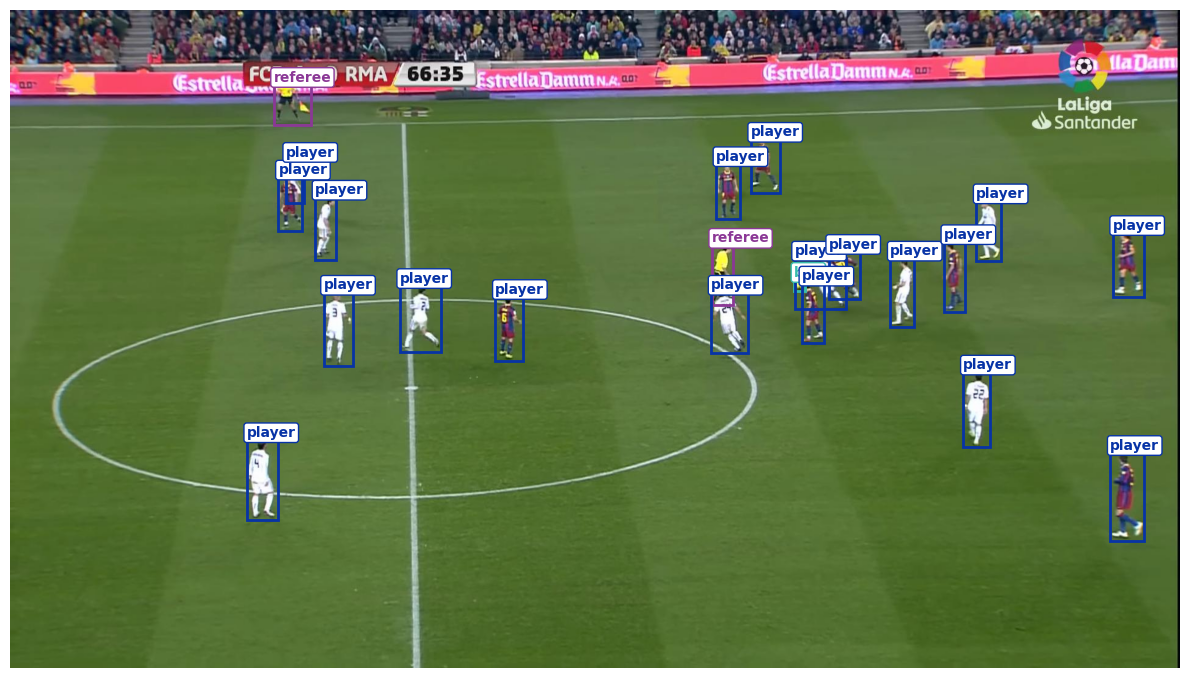

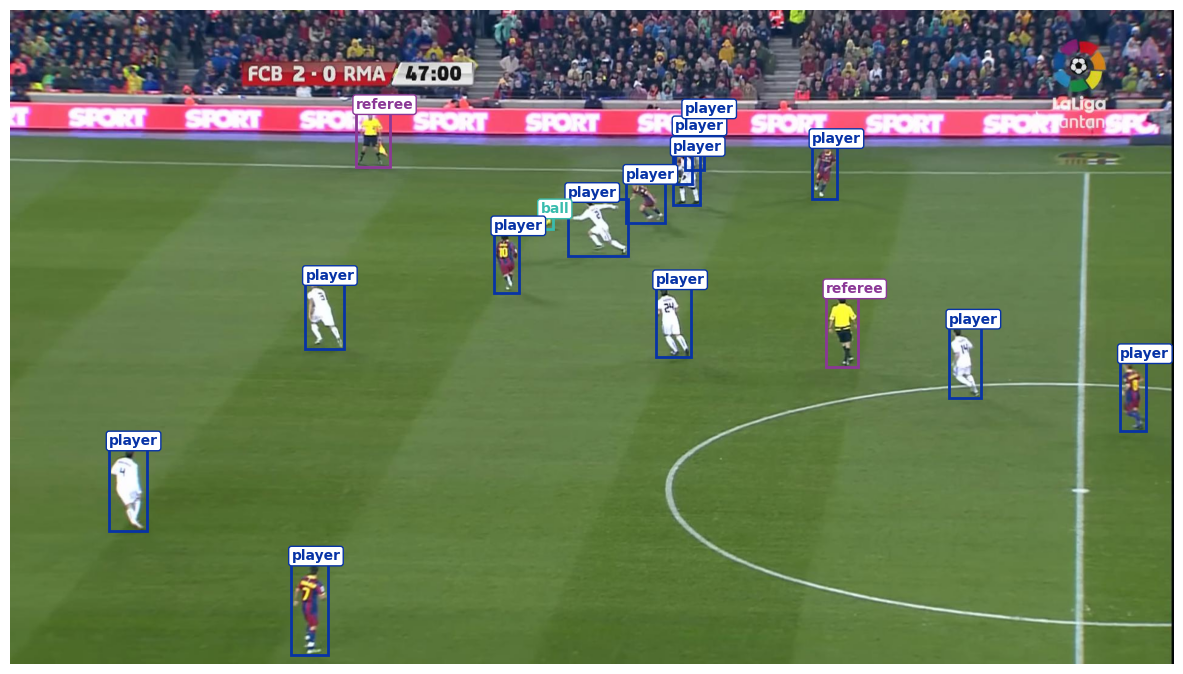

In [188]:
# VISUALIZE IMAGES OF TRAINING DATASET

# Load COCO annotation file
with open("dataset/train/_annotations.coco.json", "r") as f:
    coco = json.load(f)

# Index data
images = {img["id"]: img for img in coco["images"]}
annotations = coco["annotations"]
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Assign distinct random colors to each class
random.seed(42)  # For reproducibility
category_colors = {
    cat_id: [random.random() for _ in range(3)] for cat_id in categories.keys()
}

# Function to visualize image with bounding boxes
def visualize_image(image_id, image_dir):
    img_info = images[image_id]
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = Image.open(img_path)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for ann in annotations:
        if ann["image_id"] == image_id:
            bbox = ann["bbox"]
            cat_id = ann["category_id"]
            color = category_colors[cat_id]
            label = categories[cat_id]

            # Draw bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)

            # Draw label
            ax.text(
                bbox[0], bbox[1] - 4, label,
                color=color, fontsize=10, weight='bold',
                bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2')
            )

    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Change this to view different images
image_directory = "dataset/train"
for i, image_id in enumerate(images):
    if i >= 2:  # Display first 2 images
        break
    visualize_image(image_id, image_directory)


### Train Neural Network

#### Dataset class

This dataset class, CocoDetectionTransform, efficiently loads images and bounding box annotations from a COCO-formatted dataset for multi-class object detection tasks. Each image is paired with a dictionary containing resized bounding boxes and 0-indexed class labels, ready to be used with PyTorch detection models like RetinaNet or Faster R-CNN.

The dataset supports optional image transformations (e.g., resizing, normalization, and data augmentation) to improve training robustness. It ensures that bounding boxes are automatically adjusted when images are resized or augmented, providing a seamless workflow for model training and evaluation.

Arguments:

* img_folder: Directory with input images

* ann_file: COCO-format annotation JSON

* transforms: Optional callable for image and bounding box transformations

In [189]:
# Custom CocoDataset with transforms for images and bounding boxes
from chitra.image import Chitra
class CocoDetectionTransform(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self.transforms = transforms
        self.coco = COCO(ann_file)

        # Get valid category IDs
        self.valid_category_ids = sorted([
            cat["id"] for cat in self.coco.dataset["categories"]
            if cat["name"] != "football-objects"
        ])
        self.cat_id_map = {cat_id: idx for idx, cat_id in enumerate(self.valid_category_ids)}  # COCO ID → 0-indexed
        self.to_pil = T.ToPILImage()

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        # Collect bounding box and label information
        for obj in anns:
            if obj["category_id"] not in self.cat_id_map:
                continue

            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])

            mapped_id = self.cat_id_map[obj['category_id']]  # Convert to 0-based
            labels.append(mapped_id)


        

        # Use Chitra to resize the image and adjust the bounding boxes
        img = self.to_pil(img)
        chitra_image = Chitra(img, boxes, labels)
        img_resized, boxes_resized = chitra_image.resize_image_with_bbox((1000, 1000))

        # print(f"Original image shape: {img.size}")
        # print(f"Original bounding boxes: {boxes}")

        boxes_resized_list = []
        for bbox in boxes_resized:
            x1, y1, x2, y2 = bbox.x1, bbox.y1, bbox.x2, bbox.y2
            boxes_resized_list.append([x1, y1, x2, y2])
        

        # print(f"Resized image shape: {img_resized.size}")
        # print(f"Resized bounding boxes: {boxes_resized_list}")        





        # Prepare the target dict with resized bounding boxes
        target_dict = {
            'boxes': torch.tensor(boxes_resized_list, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id])
        }

        # Apply additional transformations if provided
        if self.transforms:
            img_resized, target_dict['boxes'] = self.transforms(img_resized, target_dict['boxes'])

        return img_resized, target_dict


    
# --- Transformations ---

def get_transform(train=True):
    transforms = []
    transforms.append(T2.ToTensor())
    # transforms.append(T2.ToImagePIL)
    # transforms.append(T2.ToDtype(torch.float32))  # like ToTensor()
    # transforms.append(T2.Resize((512, 512)))  # Resize to 512, 512
        # transforms += [
        #     T2.Resize((240, 240)),  # Resize to 426, 240
        #     T2.ColorJitter(0.2, 0.2, 0.2),
        #     T2.RandomHorizontalFlip(0.5),
        #     T2.RandomRotation(degrees=15),  # Random rotation within 15 degrees
        #     T2.RandomResizedCrop(size=(800, 800), scale=(0.8, 1.0)),  # Random crop and resize
        #     T2.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformations
        #     T2.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective transformation
        # ]
    
    return T2.Compose(transforms)



#### Models

In [190]:
import torchvision
from torchvision.models.detection import FasterRCNN, RetinaNet, ssd300_vgg16
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

# --- RetinaNet Model ---
def get_retinanet_model(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    
    # Modify the classification head
    num_anchors = model.head.classification_head.num_anchors
    in_features = model.backbone.out_channels
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=in_features, num_anchors=num_anchors, num_classes=num_classes
    )
    return model

# --- Faster R-CNN Model ---
def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model



# --- Model selector ---
def get_model_by_name(name, num_classes):
    """
    Returns a detection model based on the string name.
    
    Args:
        name (str): 'retinanet', 'fasterrcnn', or 'ssd'
        num_classes (int): number of classes including background (usually 1+objects)
    """
    name = name.lower()
    if name == "retinanet":
        return get_retinanet_model(num_classes)
    elif name == "fasterrcnn":
        return get_fasterrcnn_model(num_classes)
    else:
        raise ValueError(f"Unknown model name: {name}. Choose from 'retinanet', 'fasterrcnn'")

#### Train Loop

In [191]:
@torch.no_grad()
def evaluate_model(model, val_loader, device):
    model.train()  # temporary train mode so losses are returned
    total_val_loss = 0.0

    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_val_loss += sum(loss for loss in loss_dict.values()).item()

    return total_val_loss / len(val_loader)


import matplotlib.pyplot as plt

def train_and_eval_model(model, train_loader, val_loader, device, num_epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Lists to store loss values per epoch
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        progress_bar = tqdm(train_loader, desc=f"Training", leave=False)

        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
            progress_bar.set_postfix(loss=losses.item())

        lr_scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")

        # ---- VALIDATION STEP ----
        val_loss = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1} | Validation Loss: {val_loss:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), f"models/{model.__class__.__name__}_epoch{epoch+1}.pth")

    # ---- PLOT CURVES ----
    plt.figure(figsize=(8,5))
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses



In [192]:
# import torch
# import torchvision
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # ---- Evaluation function with metrics ----
# @torch.no_grad()
# def evaluate_model_metrics(model, val_loader, device):
#     """
#     Returns validation loss, average number of detections per image,
#     average IoU, and class accuracy
#     """
#     model.train()  # temporary train mode to compute loss
#     total_val_loss = 0.0
#     total_detections = 0
#     total_iou = 0.0
#     total_correct_labels = 0
#     total_labels = 0
#     num_images = 0

#     for images, targets in val_loader:
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # ---- Loss ----
#         loss_dict = model(images, targets)
#         total_val_loss += sum(loss for loss in loss_dict.values()).item()

#         # ---- Predictions ----
#         outputs = model(images, targets)  # list of dicts

#         for out, t in zip(outputs, targets):
#             pred_boxes = out['boxes']
#             pred_labels = out['labels']
#             gt_boxes = t['boxes']
#             gt_labels = t['labels']

#             num_images += 1
#             total_detections += len(pred_boxes)
#             total_labels += len(gt_labels)

#             # ---- Average IoU ----
#             if len(pred_boxes) > 0 and len(gt_boxes) > 0:
#                 ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
#                 max_ious, _ = ious.max(dim=1)
#                 total_iou += max_ious.sum().item()

#             # ---- Class Accuracy ----
#             if len(pred_boxes) > 0 and len(gt_boxes) > 0:
#                 ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
#                 for p_idx in range(len(pred_boxes)):
#                     max_iou, gt_idx = ious[p_idx].max(0)
#                     if max_iou >= 0.5:
#                         if pred_labels[p_idx] == gt_labels[gt_idx]:
#                             total_correct_labels += 1

#     avg_val_loss = total_val_loss / len(val_loader)
#     avg_detections = total_detections / num_images
#     avg_iou = total_iou / max(total_detections, 1)
#     class_acc = total_correct_labels / max(total_labels, 1)

#     return avg_val_loss, avg_detections, avg_iou, class_acc


# # ---- Training function ----
# def train_and_eval_model(model, train_loader, val_loader, device, num_epochs=10):
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0.0
#         print(f"\nEpoch {epoch + 1}/{num_epochs}")

#         progress_bar = tqdm(train_loader, desc="Training", leave=False)
#         for images, targets in progress_bar:
#             images = [img.to(device) for img in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())

#             optimizer.zero_grad()
#             losses.backward()
#             optimizer.step()

#             total_loss += losses.item()
#             progress_bar.set_postfix(loss=losses.item())

#         lr_scheduler.step()
#         avg_train_loss = total_loss / len(train_loader)
#         train_losses.append(avg_train_loss)
#         print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")

#         # ---- Validation step with metrics ----
#         val_loss, avg_det, avg_iou, class_acc = evaluate_model_metrics(model, val_loader, device)
#         val_losses.append(val_loss)
#         print(f"Epoch {epoch+1} | Validation Loss: {val_loss:.4f} | "
#               f"Avg Detections: {avg_det:.2f} | Avg IoU: {avg_iou:.4f} | Class Acc: {class_acc:.4f}")

#         # Save checkpoint
#         torch.save(model.state_dict(), f"models/{model.__class__.__name__}_epoch{epoch+1}.pth")

#     # ---- Plot Loss Curves ----
#     plt.figure(figsize=(8,5))
#     plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
#     plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training and Validation Loss Curves")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return train_losses, val_losses


#### Data loaders

In [193]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

validation_dir = f"{dataset_dir}/val"

train_dataset = CocoDetectionTransform(
    img_folder=f'{training_dir}/',
    ann_file=f'{training_dir}/_annotations.coco.json',
    transforms=get_transform(train=True)
)

val_dataset = CocoDetectionTransform(
    img_folder=f'{validation_dir}/',
    ann_file=f'{validation_dir}/_annotations.coco.json',
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)))

c:\Users\luigi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


#### RetinaNet

c:\Users\luigi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luigi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/5


Epoch 1 | Training Loss: 0.5565
Epoch 1 | Validation Loss: 0.4833

Epoch 2/5


Epoch 2 | Training Loss: 0.3543
Epoch 2 | Validation Loss: 0.3675

Epoch 3/5


Epoch 3 | Training Loss: 0.2976
Epoch 3 | Validation Loss: 0.3610

Epoch 4/5


Epoch 4 | Training Loss: 0.2221
Epoch 4 | Validation Loss: 0.2688

Epoch 5/5


Epoch 5 | Training Loss: 0.2020
Epoch 5 | Validation Loss: 0.2647


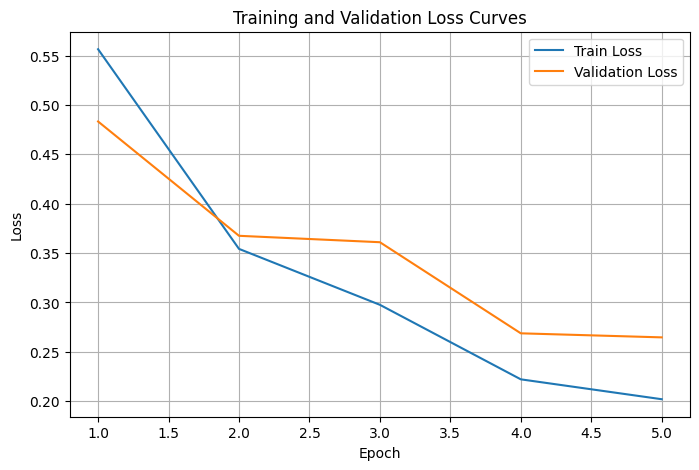

In [194]:
model = get_model_by_name("retinanet", num_classes=5)

train_losses_r, val_losses_r = train_and_eval_model(model, train_loader, val_loader, device, num_epochs=5)

#### Faster RCNN

In [195]:
# model = get_model_by_name("fasterrcnn", num_classes=5)

# train_losses_f, val_losses_f = train_and_eval_model(model, train_loader, val_loader, device, num_epochs=5)

In [196]:
# # --- Training Function (No Validation) ---


# def train_model(model, train_loader, device, num_epochs=10):
#     model.to(device)
#     # optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
#     optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
    
#     lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0.0

#         print(f"\nEpoch {epoch + 1}/{num_epochs}")
#         progress_bar = tqdm(train_loader, desc=f"Training", leave=False)

#         for images, targets in progress_bar:
#             images = [img.to(device) for img in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())

#             optimizer.zero_grad()
#             # (losses/len(train_loader)).backward()
#             losses.backward()
#             optimizer.step()

#             # batch_loss = losses.item() / len(train_loader)
#             batch_loss = losses.item()
#             total_loss += batch_loss

#             # avg_loss = total_loss / len(train_loader)
#             progress_bar.set_postfix(loss=batch_loss)

#         lr_scheduler.step()
#         print(f"Epoch {epoch + 1} | Avg Loss: {batch_loss:.4f}")
#         torch.save(model.state_dict(), f"retinanet_epoch{epoch+1}.pth")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# train_dataset = CocoDetectionTransform(
#     img_folder=f'{training_dir}/',
#     ann_file=f'{training_dir}/_annotations.coco.json',
#     transforms=get_transform(train=True)
# )

# # train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# train_loader = DataLoader(
# train_dataset,
# batch_size=8,
# shuffle=True,
# collate_fn=lambda x: tuple(zip(*x)),  # essential for detection
# # num_workers=4,  # Adjust based on your CPU cores
# # pin_memory=True  # For faster data transfer to GPU
# # persistent_workers=True  # Keep workers alive for faster data loading
# )


# num_classes = 5 # player, ball, referee, coach, goalkeeper 
# model = get_retinanet_model(num_classes)

# print("Model loaded.")
# print("Training started...")
# # train_model(model, train_loader, device, num_epochs=5)
# print("Training completed.")

### Predictions from neural network

In [197]:
# model.load_state_dict(torch.load("FasterRCNN_epoch5.pth"))
# model.eval()
# model.to(device)

# # Get one sample from dataset
# img, target = train_dataset[30]

# with torch.no_grad():
#     prediction = model([img.to(device)])[0]  # Batch of one

# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Move image back to CPU and convert to NumPy
# img_np = img.permute(1, 2, 0).cpu().numpy()

# # Plot the image
# plt.figure(figsize=(20, 20))
# plt.imshow(img_np)
# ax = plt.gca()

# # Draw predicted boxes (use a confidence threshold)
# confidence_threshold = 0.6
# for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
#     if score < confidence_threshold:
#         continue
#     x1, y1, x2, y2 = box.cpu().numpy()
#     width, height = x2 - x1, y2 - y1
#     rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='lime', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(x1, y1 - 10, f"Class {label.item()} | {score:.2f}", color='lime', backgroundcolor='black')

# plt.title("Predictions from RetinaNet")
# plt.axis("off")
# plt.show()


In [ ]:
Create a test dataset

test_dir = f"{dataset_dir}/test"
test_files = os.listdir(test_dir)
test_csv = 'dataset/test.csv'

test_df = pd.read_csv(test_csv)
# test_df.head()

Image: 33


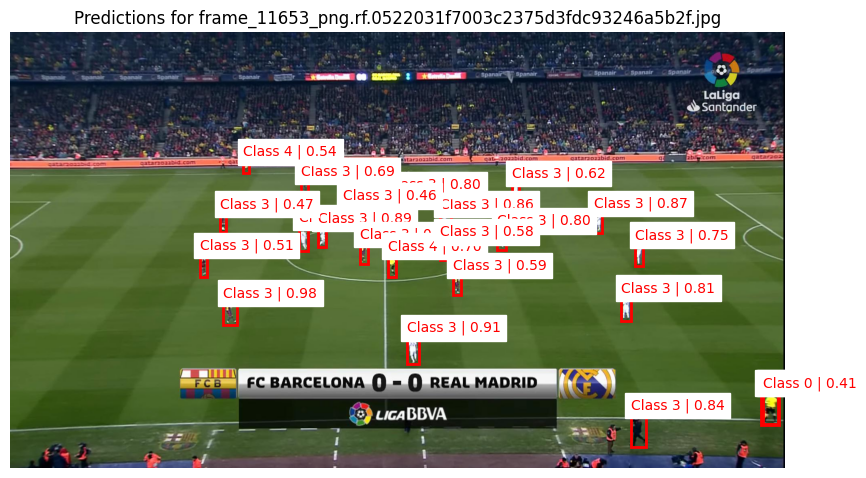

In [212]:
# Predict on test images
for i, row in test_df.iterrows():
    if i== 50:
        img_path = os.path.join(test_dir, row['img_name'])
        if not os.path.exists(img_path):
            print(f"Image {img_path} does not exist.")
            continue

        # Load the image
        img = Image.open(img_path).convert("RGB")
        img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)

        # Make predictions
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Filter predictions based on confidence threshold
        confidence_threshold = 0.4
        boxes = prediction['boxes'][prediction['scores'] > confidence_threshold].cpu().numpy()
        labels = prediction['labels'][prediction['scores'] > confidence_threshold].cpu().numpy()
        scores = prediction['scores'][prediction['scores'] > confidence_threshold].cpu().numpy()

        # Print or save the results as needed
        print(f"Image: {row['img_id']}")
        # for box, label, score in zip(boxes, labels, scores):
        #     print(f"  Box: {box}, Label: {label}, Score: {score:.2f}")
        # Show the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        ax = plt.gca()
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 10, f"Class {label} | {score:.2f}", color='red', backgroundcolor='white')
        plt.title(f"Predictions for {row['img_name']}")
        plt.axis("off")
        plt.show()
        

In [215]:
import torch
from torchvision.ops import box_iou
from tqdm import tqdm

@torch.no_grad()
def evaluate_val_set(model, val_loader, device, confidence_threshold=0.5):
    model.eval()
    total_detections = 0
    total_iou = 0.0
    total_correct_labels = 0
    total_labels = 0
    num_images = 0

    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for out, t in zip(outputs, targets):
            pred_boxes = out['boxes']
            pred_labels = out['labels']
            pred_scores = out['scores']

            # Filter predictions by confidence threshold
            mask = pred_scores >= confidence_threshold
            pred_boxes = pred_boxes[mask]
            pred_labels = pred_labels[mask]
            pred_scores = pred_scores[mask]

            gt_boxes = t['boxes']
            gt_labels = t['labels']

            num_images += 1
            total_detections += len(pred_boxes)
            total_labels += len(gt_labels)

            # Average IoU
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)
                max_ious, _ = ious.max(dim=1)
                total_iou += max_ious.sum().item()

            # Class accuracy (correct label for matching boxes)
            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                ious = box_iou(pred_boxes, gt_boxes)
                for p_idx in range(len(pred_boxes)):
                    max_iou, gt_idx = ious[p_idx].max(0)
                    if max_iou >= 0.5 and pred_labels[p_idx] == gt_labels[gt_idx]:
                        total_correct_labels += 1

    avg_detections = total_detections / max(num_images, 1)
    avg_iou = total_iou / max(total_detections, 1)
    class_acc = total_correct_labels / max(total_labels, 1)

    print(f"Validation Metrics on {num_images} images (confidence >= {confidence_threshold}):")
    print(f"- Average Detections per Image: {avg_detections:.2f}")
    print(f"- Average IoU: {avg_iou:.4f}")
    print(f"- Class Accuracy: {class_acc:.4f}")


In [216]:
model = get_retinanet_model(num_classes=5)
# model.load_state_dict(torch.load("models/RetinaNet_epoch3.pth"))
model.load_state_dict(torch.load("retinanet_0.20.pth"))
model.eval()
model.to(device)
evaluate_val_set(model, val_loader, device)

c:\Users\luigi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luigi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|██████████| 160/160 [00:21<00:00,  7.37it/s]

Validation Metrics on 160 images (confidence >= 0.5):
- Average Detections per Image: 17.99
- Average IoU: 0.8724
- Class Accuracy: 0.9201


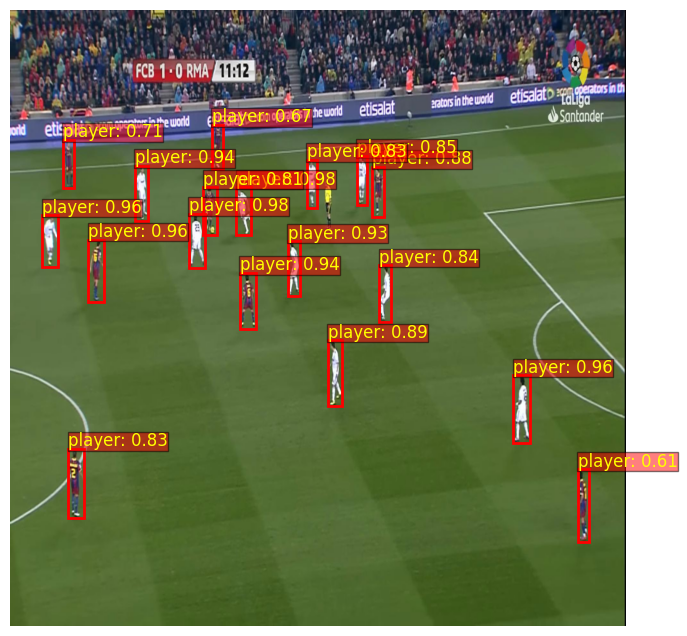

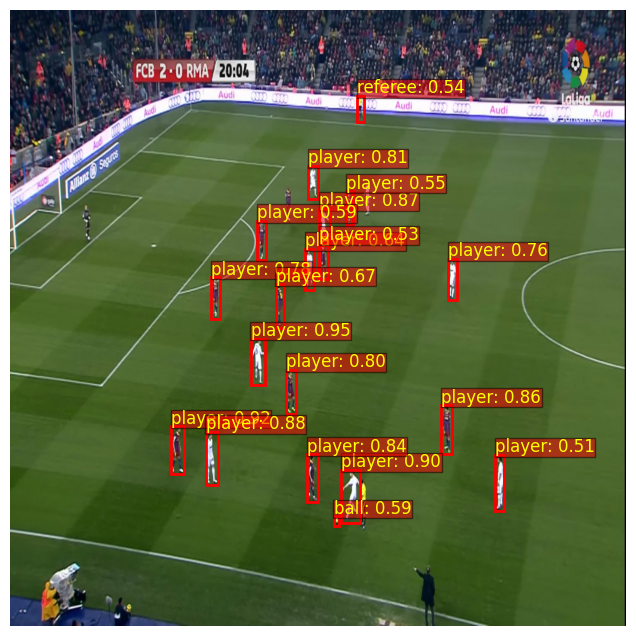

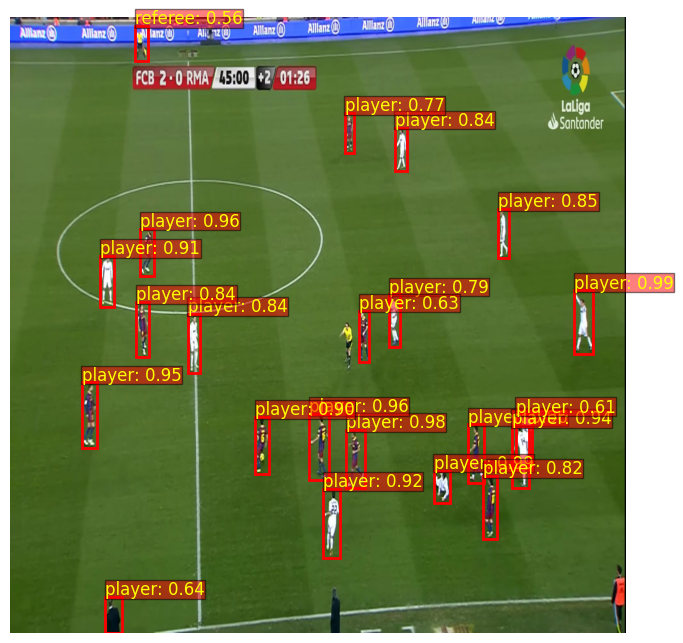

In [214]:
import matplotlib.pyplot as plt

# Define class names
class_names = ['ball', 'coach', 'goalkeeper', 'player', 'referee']

def visualize_predictions(model, val_loader, device, num_images=5, confidence_threshold=0.5):
    model.eval()
    for i, (images, targets) in enumerate(val_loader):
        if i >= num_images:
            break

        image = images[0].to(device)
        output = model([image])[0]

        # Convert image to HWC format for matplotlib
        img = image.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(8, 8))
        plt.imshow(img)

        boxes = output['boxes']
        labels = output['labels']
        scores = output['scores']

        for box, label, score in zip(boxes, labels, scores):
            if score < confidence_threshold:
                continue  # skip low-confidence predictions

            x1, y1, x2, y2 = box.detach().cpu().numpy()
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, color='red', linewidth=2
            ))

            class_name = class_names[label.item()]  # map label to class
            plt.text(
                x1, y1 - 4, f'{class_name}: {score:.2f}',  # show confidence
                color='yellow', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5, pad=0.2)
            )

        plt.axis('off')
        plt.show()

visualize_predictions(model, val_loader, device, num_images=3, confidence_threshold=0.5)